### 必要なモジュールのimport

In [1]:
import warnings
import time
import pickle

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_score, recall_score, fbeta_score, confusion_matrix, precision_recall_curve, accuracy_score, mean_squared_error
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline
from imblearn.metrics import classification_report_imbalanced
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, KFold, GridSearchCV
from collections import Counter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 500)

In [2]:
# データの読み込み(02_data_preparation.ipynbで作成したデータ)
train = pd.read_csv('../data/processed/processed20240621_train.csv')
train_ori = pd.read_csv('../data/processed/processed20240621_train.csv')
test = pd.read_csv('../data/processed/processed20240621_test.csv')

## targetの分布の確認

In [3]:
# targetの正規化
scaler = MinMaxScaler()
train['target'] = scaler.fit_transform(train[['target']])

C:\Users\kento.nishino.ek\AppData\Local\Temp\ipykernel_19876\2946955093.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['target'])


<Axes: xlabel='target', ylabel='Density'>

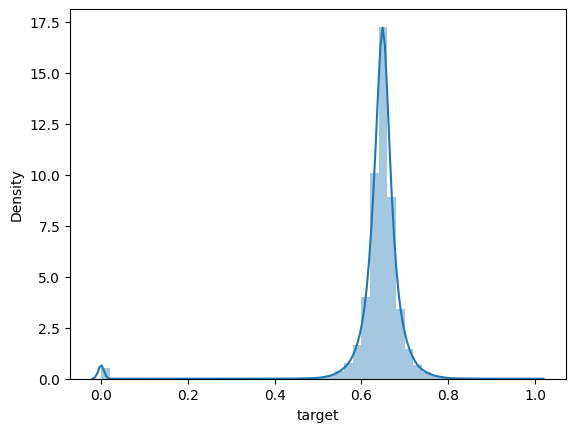

In [4]:
# 目的変数の分布を確認
sns.distplot(train['target'])

<Axes: xlabel='target'>

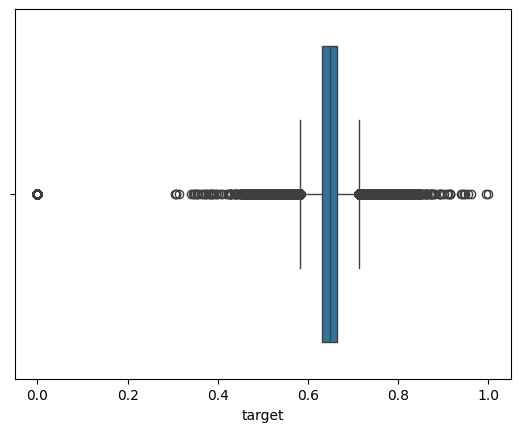

In [5]:
# 箱ひげ図
sns.boxplot(x='target', data=train)

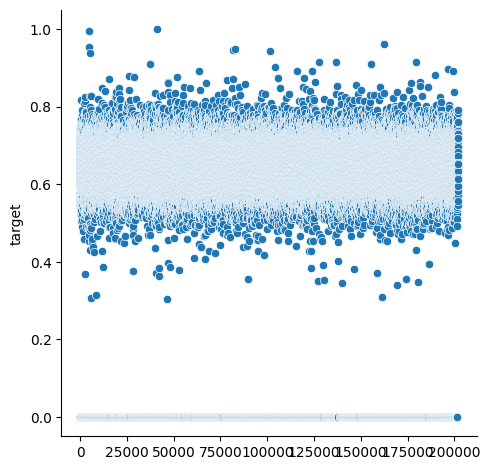

In [6]:
sns.relplot(data=train['target'])

ここまでグラフを見てみると特に0.1未満の数字の部分が特に外れ値であると考えられます。   
今回のコンペの評価指標がRMSEとなっていることもあり、こうした極端な外れ値に対してもきちんと予測できないと精度は悪化してしまうため外れ値のフラグを立ててそれを特徴量ととして実装していきましょう。

In [7]:
# 最小値を算出
train['target'].min()

0.0

In [8]:
# ロイヤリティの値が最小値であるデータの量をカウント
len(train[train['target'] == 0.0])

2207

In [9]:
# 最大値を算出
train['target'].max()

1.0

In [10]:
# ロイヤリティの値が最大値であるデータの量をカウント
len(train[train['target'] == 1.0])

1

In [11]:
# カウント範囲を設定
range_min = 0.5
range_max = train['target'].min() - 0.1  # -10より小さい最小値を設定
ranges = np.arange(range_max, range_min, 0.1)  # 0.1刻みで範囲を生成

# カウントを行う
counts = [len(train[train['target'] < r]) for r in ranges]

# データフレームにまとめる
count_df = pd.DataFrame({'範囲': ranges, 'データの個数': counts})
count_df

,範囲,データの個数
0,-0.1,0
1,0.0,0
2,0.1,2207
3,0.2,2207
4,0.3,2207
5,0.4,2232


ロイヤリティの値が最小値であるデータの個数が2207に対して最大値であるデータの量は1となっており、明らかに-33.21928095の値が異常であることが考えられます(仮説：長期滞納者などをひとまとめにしている？)

また0.0から0.1刻みにそれ未満のデータ数がどれだけ存在するかを調べてみると0.5未満までは最小値と同じデータ数になるため、明らかに0.0の値が断絶していることが確認できます。  

## lightGBMモデルの作成

In [12]:
# 目的変数と説明変数の作成
target = train['target']
del train['target']

In [13]:
# lightgbmのパラメータ
param = {'num_leaves': 111,
         'min_data_in_leaf': 149, 
         'objective':'regression',
         'max_depth': 9,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.7522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2634,
         "random_state": 133,
         "verbosity": -1}

In [14]:
# 特徴量の情報
features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
categorical_feats = ['feature_2', 'feature_3']

In [15]:
# データをKFoldで5分割して学習
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(params=param,
                    train_set=trn_data,
                    num_boost_round=num_round,
                    valid_sets=[val_data],
                    callbacks=[lgb.early_stopping(stopping_rounds=200),
                               lgb.log_evaluation(100)])

    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits
    
    # モデルを保存
    with open(f'../src/models/model_fold_{fold_}.pkl', 'wb') as f:
        pickle.dump(clf, f)
    
print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n°0
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 0.0737924
[200]	valid_0's rmse: 0.0728655
[300]	valid_0's rmse: 0.0724045
[400]	valid_0's rmse: 0.0721611
[500]	valid_0's rmse: 0.0720098
[600]	valid_0's rmse: 0.0719151
[700]	valid_0's rmse: 0.0718603
[800]	valid_0's rmse: 0.0718218
[900]	valid_0's rmse: 0.0717881
[1000]	valid_0's rmse: 0.0717636
[1100]	valid_0's rmse: 0.0717526
[1200]	valid_0's rmse: 0.071744
[1300]	valid_0's rmse: 0.0717362
[1400]	valid_0's rmse: 0.0717332
[1500]	valid_0's rmse: 0.0717236
[1600]	valid_0's rmse: 0.0717237
[1700]	valid_0's rmse: 0.0717204
[1800]	valid_0's rmse: 0.0717166
[1900]	valid_0's rmse: 0.0717158
Early stopping, best iteration is:
[1765]	valid_0's rmse: 0.0717148
fold n°1
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 0.072401
[200]	valid_0's rmse: 0.0715516
[300]	valid_0's rmse: 0.0711404
[400]	valid_0's rmse: 0.0709357
[500]	valid_0's rmse: 0.0708349
[600]	valid_0'

## 特徴量重要度

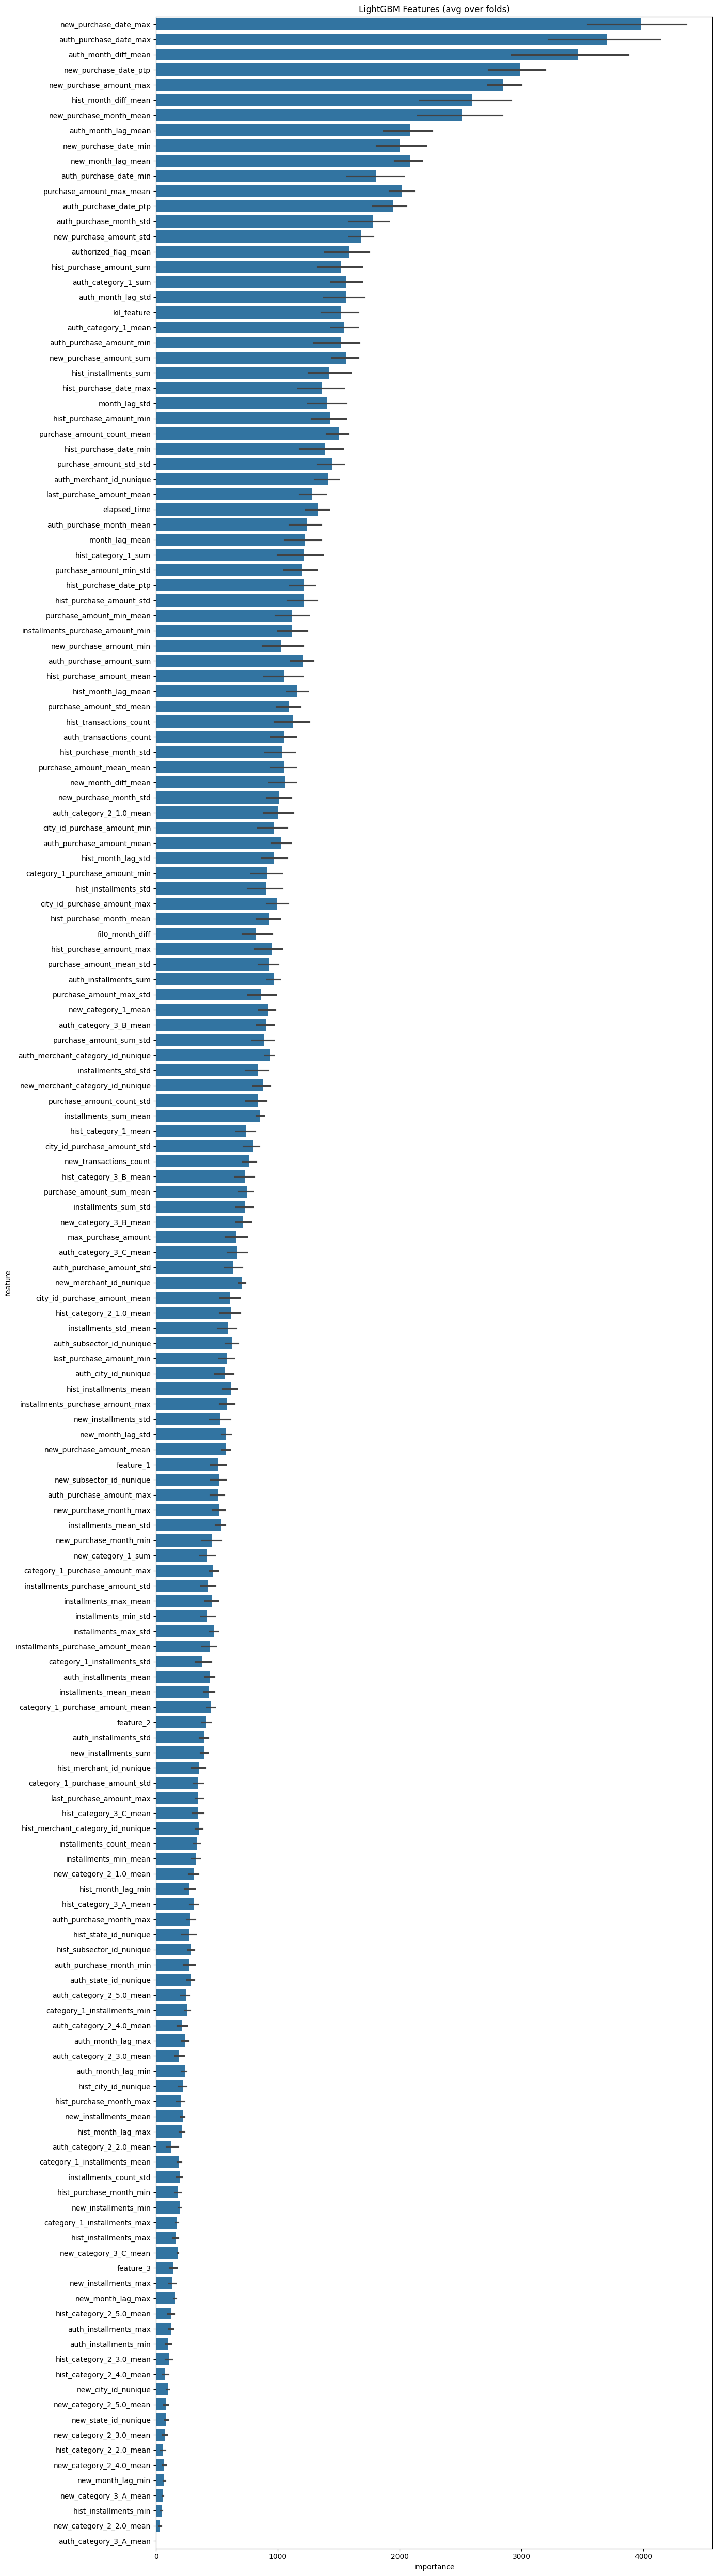

In [16]:
# 特徴量重要度の可視化
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
# plt.savefig('lgbm_importances.png')

## 提出ファイルの作成

C:\Users\kento.nishino.ek\AppData\Local\Temp\ipykernel_19876\2907542931.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(predictions)


<Axes: ylabel='Density'>

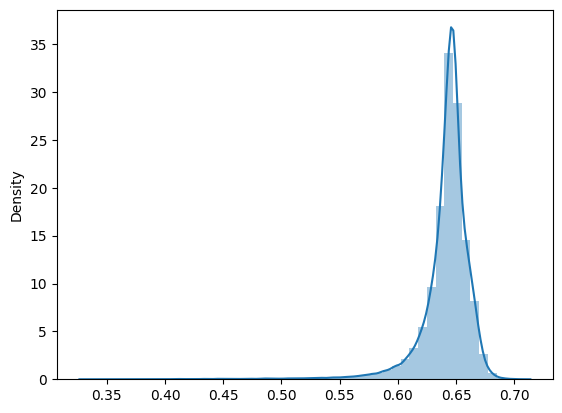

In [17]:
# 目的変数の分布を確認
sns.distplot(predictions)

In [18]:
# 予測値の逆変換
predictions_original_scale = scaler.inverse_transform(predictions.reshape(-1, 1))
# predictions_original_scaleには目的変数の元のスケールでの予測値が格納される


C:\Users\kento.nishino.ek\AppData\Local\Temp\ipykernel_19876\1120668632.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(predictions_original_scale)


<Axes: ylabel='Density'>

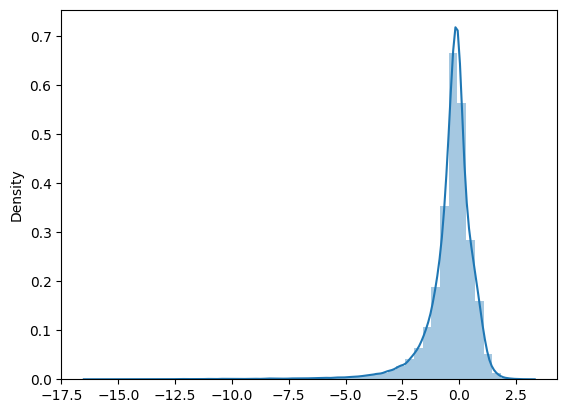

In [19]:
# 目的変数の分布を確認
sns.distplot(predictions_original_scale)

In [20]:
sub_df = pd.DataFrame({"card_id":test["card_id"].values})
sub_df["target"] = predictions_original_scale
sub_df.to_csv("submit.csv", index=False)